In [1]:
import torch.nn as nn
import librosa
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import IPython.display as ipd


In [2]:
s, sr=librosa.load('data/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)


In [3]:
s_abs = np.abs(S)
x_abs = np.abs(X)

In [4]:
s = torch.tensor(np.transpose(s_abs)).cuda()
x = torch.tensor(np.transpose(x_abs)).cuda()
BATCH = 171


In [5]:
train_loader = torch.utils.data.DataLoader(x, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(s, batch_size=BATCH)


In [6]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.input_layer = nn.Linear(513, 2459)
    self.hidden_layer1 = nn.Linear(2459, 2459)
    self.hidden_layer2 = nn.Linear(2459, 2459)
    self.output_layer = nn.Linear(2459, 513)
    
    self.activation = nn.ReLU()

  def forward(self, data):
    data = data.view(-1, 513).cuda()
    output = self.activation(self.input_layer(data))
    output = self.activation(self.hidden_layer1(output))
    output = self.activation(self.hidden_layer2(output))
    output_layer = self.output_layer(output)
    final = torch.nn.functional.relu(output_layer)
    return final


tensor(0.0003, device='cuda:0')


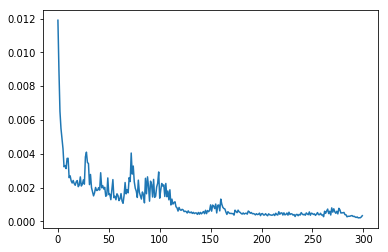

In [7]:
# using Adam with learning rat .001 keeping everything else default.
neural_network = NeuralNet()
neural_network = neural_network.cuda()
loss_function= nn.MSELoss()
para = neural_network.parameters()
optimizer = torch.optim.Adam(params=para, lr=0.001)
loss_list = []
epochs = 300
for i in range(epochs):
    input_iter = iter(train_loader)
    target_iter = iter(test_loader)
    while True:
        try:
            input_set = input_iter.next()
            target_set = target_iter.next()
            input_set = input_set.cuda()
            target_set = target_set.cuda()
            optimizer.zero_grad()
            network_output  = neural_network(input_set)
            loss = loss_function(network_output , target_set)
            loss.backward()
            optimizer.step()
        except StopIteration:
            break
    loss_list.append(loss.data.cpu().numpy())
print(loss.data)
plt.plot(range(epochs), loss_list)
plt.show()   

In [8]:
# common function for testing the audio files
def test_audio(input_file_path, output_file_path):
    st, sr=librosa.load(input_file_path, sr=None)
    test = librosa.stft(st, n_fft=1024, hop_length=512)
    test_abs = torch.tensor(np.abs(test))
    test_abs = np.transpose(test_abs)
    test_loader = torch.utils.data.DataLoader(test_abs, batch_size=test_abs.shape[0])
    t_iter = iter(test_loader)
    with torch.no_grad():
        while True:
            try:
                data = t_iter.next()
                data = data.cuda()
                output = neural_network(data)
            except StopIteration:
                break 
        spec = (test / np.abs(test)) * output.cpu().numpy().T
        spec_istft = librosa.istft(spec, hop_length=512)
        librosa.output.write_wav(output_file_path, spec_istft, sr)

In [9]:
# testing on the audio 1
test_audio('data/test_x_01.wav', 'test_s_01_recons.wav')


In [10]:
ipd.Audio('test_s_01_recons.wav')

In [11]:
# testing on the audio 2
test_audio('data/test_x_02.wav', 'test_s_02_recons.wav')


In [12]:
ipd.Audio('test_s_02_recons.wav')

In [13]:
#checking how the original train file comes out to be
test_audio('data/train_dirty_male.wav', 'train_dirty_male_recons.wav')



In [14]:
ipd.Audio('train_dirty_male_recons.wav')